In [15]:
import pandas as pd
import SnowDepth.data_loader as DL
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Inspect data. Also includes an inspection of FF algos at the end

In [16]:
# Path to TIFF files
data_dir = "data/tif_files"

# Load dataframe (valid pixels only)
df = DL.build_df(str(data_dir), drop_invalid=True)

# Count pixels per AOI
counts = df["aoi_name"].value_counts().reset_index()
counts.columns = ["AOI", "Pixel_count"]
valid_pixels = counts["Pixel_count"].sum()

print("\nPixel count per AOI:")
print(counts.to_string(index=False))

# Build other DataFrames for comparison
df_with_invalid = DL.build_df(str(data_dir), drop_invalid=False)
total_pixels = len(df_with_invalid)

print(f"\nTotal pixels (including invalid): {total_pixels:,}")
print(f"Pixels dropped: {total_pixels-valid_pixels:,}")
print(f"Valid pixels: {valid_pixels:,}")

#Check how many how very high SD value
print(f"Pixels with SD > 3 m: {(df['SD'] > 3).sum():,}")




Pixel count per AOI:
  AOI  Pixel_count
ID_BS      1667189
CO_FR       623217
ID_DC       376213
ID_MC       344870
UT_LC       279461
CO_CP       217971

Total pixels (including invalid): 5,945,438
Pixels dropped: 2,436,517
Valid pixels: 3,508,921
Pixels with SD > 3 m: 31,118


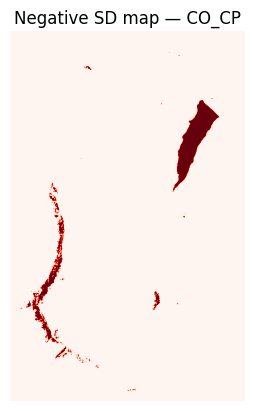

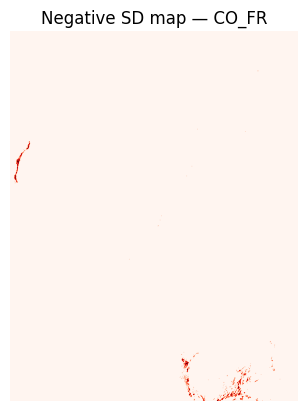

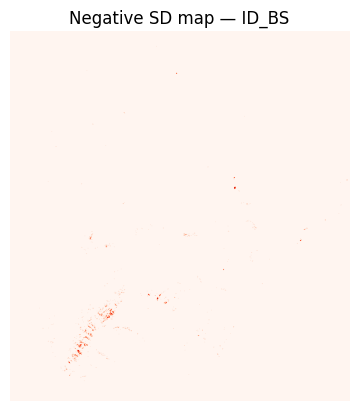

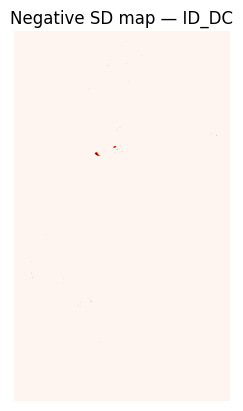

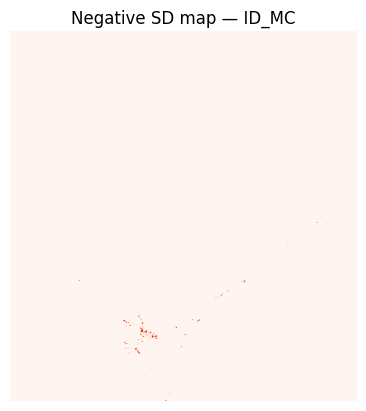

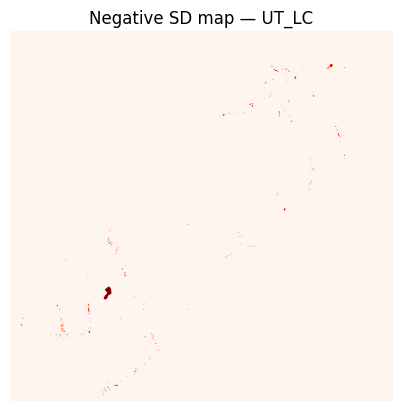


Negative SD counts per AOI:
  CO_CP: 9,380
  CO_FR: 1,916
  ID_BS: 2,362
  ID_DC: 164
  ID_MC: 299
  UT_LC: 976

Total negative SD pixels: 15,097


In [17]:
# Map negative SD values per AOI by reading each *SD.tif
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio

data_dir = "data/tif_files" 

def list_aoi_dirs(root):
    return sorted(
        os.path.join(root, d)
        for d in os.listdir(root)
        if os.path.isdir(os.path.join(root, d))
    )

aoi_dirs = list_aoi_dirs(data_dir)

total_neg = 0
aoi_neg_counts = []

for aoi_path in aoi_dirs:
    sd_files = glob(os.path.join(aoi_path, "*SD.tif"))
    if not sd_files:
        print(f"[WARN] No SD.tif found in {aoi_path}; skipping.")
        continue

    sd_path = sd_files[0]
    with rasterio.open(sd_path) as src:
        sd = src.read(1).astype(np.float32)

    neg_mask = (sd < 0)
    neg_count = int(neg_mask.sum())
    total_neg += neg_count
    name = os.path.basename(aoi_path)
    aoi_neg_counts.append((name, neg_count))

    # One plot per AOI (no subplots)
    plt.figure()
    plt.imshow(neg_mask, cmap="Reds")  # red = negative SD
    plt.title(f"Negative SD map — {name}")
    plt.axis('off')
    plt.show()

print("\nNegative SD counts per AOI:")
for name, cnt in aoi_neg_counts:
    print(f"  {name}: {cnt:,}")
print(f"\nTotal negative SD pixels: {total_neg:,}")


In [18]:
# Check descriptive statistics, click view as scrollable element to see all
pd.set_option('display.float_format', '{:.2f}'.format)
numeric_feats = [c for c in df.columns if c not in ('aoi_name','row','col')]

print("\nDescriptive Statistics:")
print(df[numeric_feats].describe().drop(index='count'))


Descriptive Statistics:
      Sigma_VH  Sigma_VV  Gamma_VH  Gamma_VV  Beta_VH  Beta_VV  Gamma_VH_RTC  \
mean    -17.34    -10.68    -16.15     -9.49   -15.45    -8.80        -17.06   
std       3.70      4.64      3.68      4.61     3.74     4.69          2.85   
min     -48.96    -38.03    -50.05    -36.27   -49.55   -35.78       -120.00   
25%     -19.61    -13.55    -18.40    -12.34   -17.75   -11.70        -18.06   
50%     -17.28    -11.33    -16.07    -10.12   -15.43    -9.48        -16.73   
75%     -15.04     -8.43    -13.85     -7.24   -13.15    -6.53        -15.65   
max      12.03     20.68     12.85     21.49    14.54    23.21         11.51   

      Gamma_VV_RTC  Sigma_sum  Gamma_sum  ...  Beta_ratio  Gamma_RTC_ratio  \
mean        -10.42       0.26       0.33  ...       -6.66            -6.64   
std           3.03       1.34       1.62  ...        2.30             2.23   
min        -120.00       0.00       0.00  ...      -34.13           -37.63   
25%         -11.61    

As we can see, there some SD values that are negative, and the max SD indicates some outliers

In [19]:
# Check for missing values, click view as scrollable element to see all
print("\nMissing Values per Column:")
print(df[numeric_feats].isna().sum())


Missing Values per Column:
Sigma_VH           0
Sigma_VV           0
Gamma_VH           0
Gamma_VV           0
Beta_VH            0
Beta_VV            0
Gamma_VH_RTC       0
Gamma_VV_RTC       0
Sigma_sum          0
Gamma_sum          0
Beta_sum           0
Gamma_RTC_sum      0
Sigma_diff         0
Gamma_diff         0
Beta_diff          0
Gamma_RTC_diff     0
Sigma_ratio        0
Gamma_ratio        0
Beta_ratio         0
Gamma_RTC_ratio    0
LIA                0
IAFE               0
Elevation          0
Slope              0
sin_Aspect         0
cos_Aspect         0
Veg_height         0
SD                 0
dtype: int64


In [20]:
# Check that filtering nan, negative and SD > 3m works (This is false SD values)
nan_rows = df['SD'].isna().sum()
print(f"NaN SD values: {nan_rows}")

negative_rows = len(df[(df['SD'] < 0)])
print(f"Negative SD values: {negative_rows}")

NaN SD values: 0
Negative SD values: 0


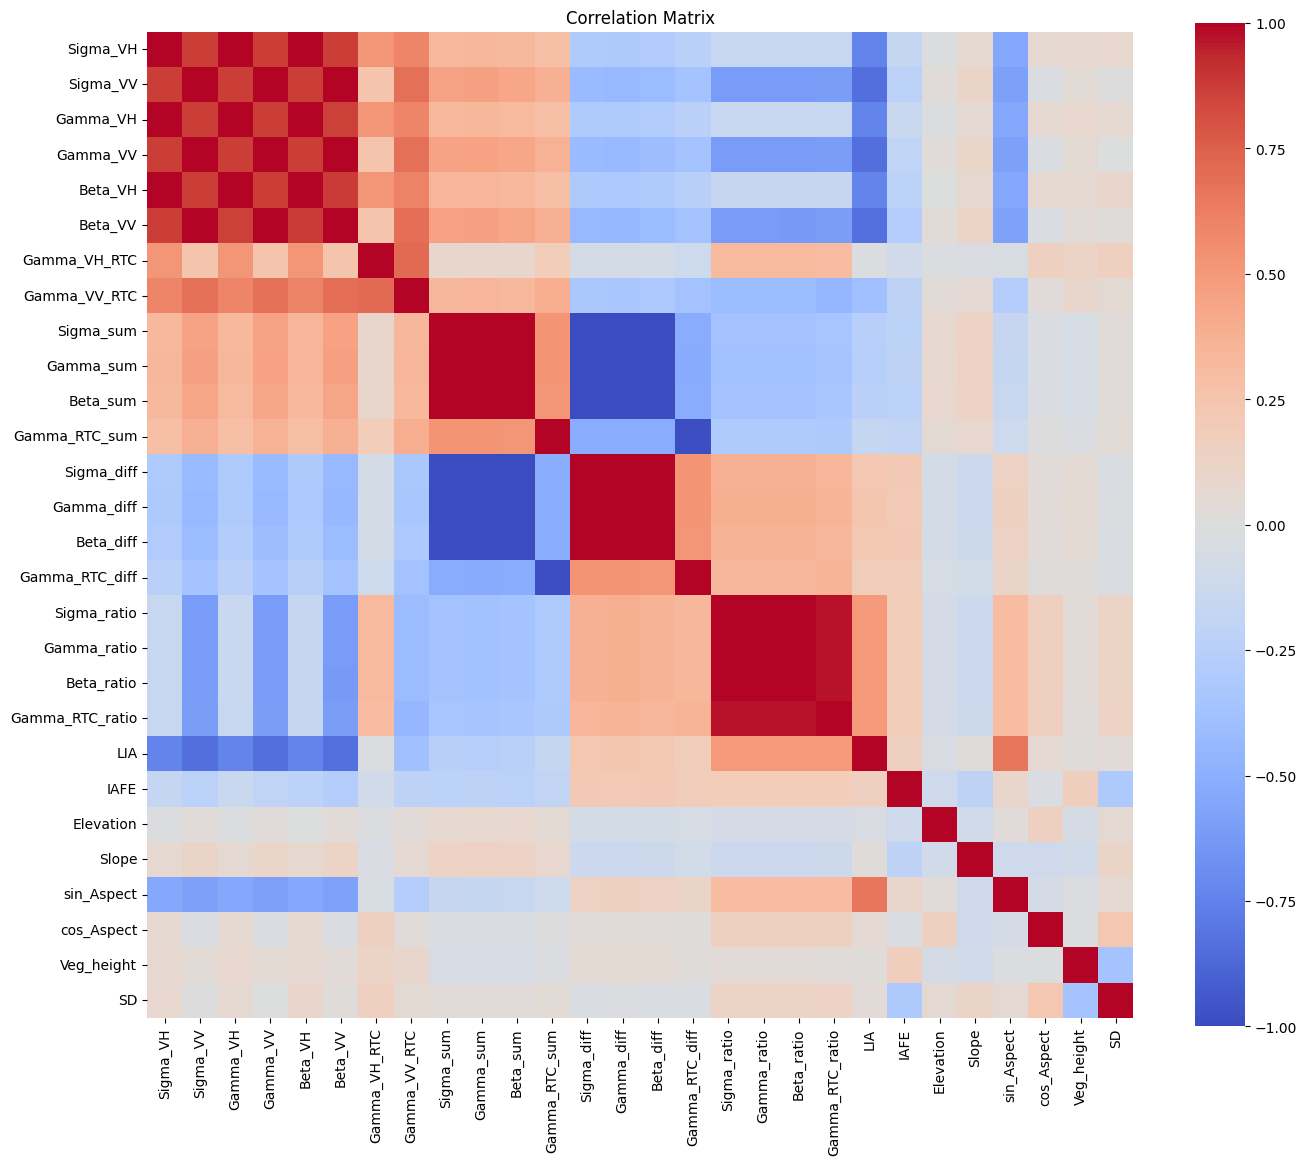

In [21]:
# Plot Correlation Matrix
variables = [c for c in df.select_dtypes(include=[np.number]).columns
             if c not in ('row','col')]

X = df[variables].replace([np.inf, -np.inf], np.nan)
corr = X.corr()

plt.figure(figsize=(max(8, 0.5*len(variables)), max(6, 0.5*len(variables))))
sns.heatmap(corr, annot=len(variables)<=15, fmt='.2f',
            cmap='coolwarm', vmin=-1, vmax=1, square=True,
            cbar_kws={'shrink': .75})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()



In [ ]:
# Inspection of FF algorithms output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SnowDepth.optimal_features as FF
from SnowDepth.optimal_features import sample_per_aoi
from SnowDepth.config import HOLDOUT_AOI, SEED

# Use development set only
dev_df = df[df["aoi_name"] != HOLDOUT_AOI].copy()

# Which columns are eligible as features
feature_cols = [c for c in dev_df.columns if c not in ("aoi_name","row","col","SD")]

TOP_K = 10


In [23]:
# Use 10000 samples to not blow up runtime
samples = sample_per_aoi(dev_df, n_per_aoi=20000)

# HSIC
hsic_selected, hsic_top = FF.hsic_lasso_select(samples, feature_cols, top_k=TOP_K)
# hsic_top has only top_k (feature, score)

# PCC
pcc_selected, pcc_rank, pcc_inter = FF.pcc_select(
    samples, feature_cols, top_k=TOP_K, max_intercorr=0.90, min_abs_corr=0.0
)

# pcc_rank has full ranking with columns ['feature','pcc','abs_pcc']
# pcc_inter is inter-correlation among the top_k candidates

# MI
mi_selected, mi_rank, mi_inter = FF.mi_select(
    samples, feature_cols, top_k=TOP_K, max_intercorr=0.90, n_neighbors=5
)

# mi_rank has full ranking with ['feature','mi']
# mi_inter is inter-correlation among the top_k candidates

print("HSIC:", hsic_selected)
print("PCC :", pcc_selected)
print("MI  :", mi_selected)


Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Gaussian kernel for the outcomes.
HSIC: ['Veg_height', 'IAFE', 'cos_Aspect', 'Gamma_VH_RTC', 'Gamma_VV_RTC', 'Slope', 'Sigma_ratio', 'Elevation', 'sin_Aspect', 'LIA', 'Beta_VH', 'Gamma_RTC_ratio']
PCC : ['Veg_height', 'IAFE', 'cos_Aspect', 'Gamma_VH_RTC', 'sin_Aspect', 'Gamma_RTC_ratio', 'Slope', 'Beta_VH']
MI  : ['IAFE', 'Elevation', 'Veg_height', 'Gamma_VH_RTC', 'Gamma_RTC_sum', 'Gamma_VV_RTC', 'Beta_VH', 'cos_Aspect', 'Beta_ratio']


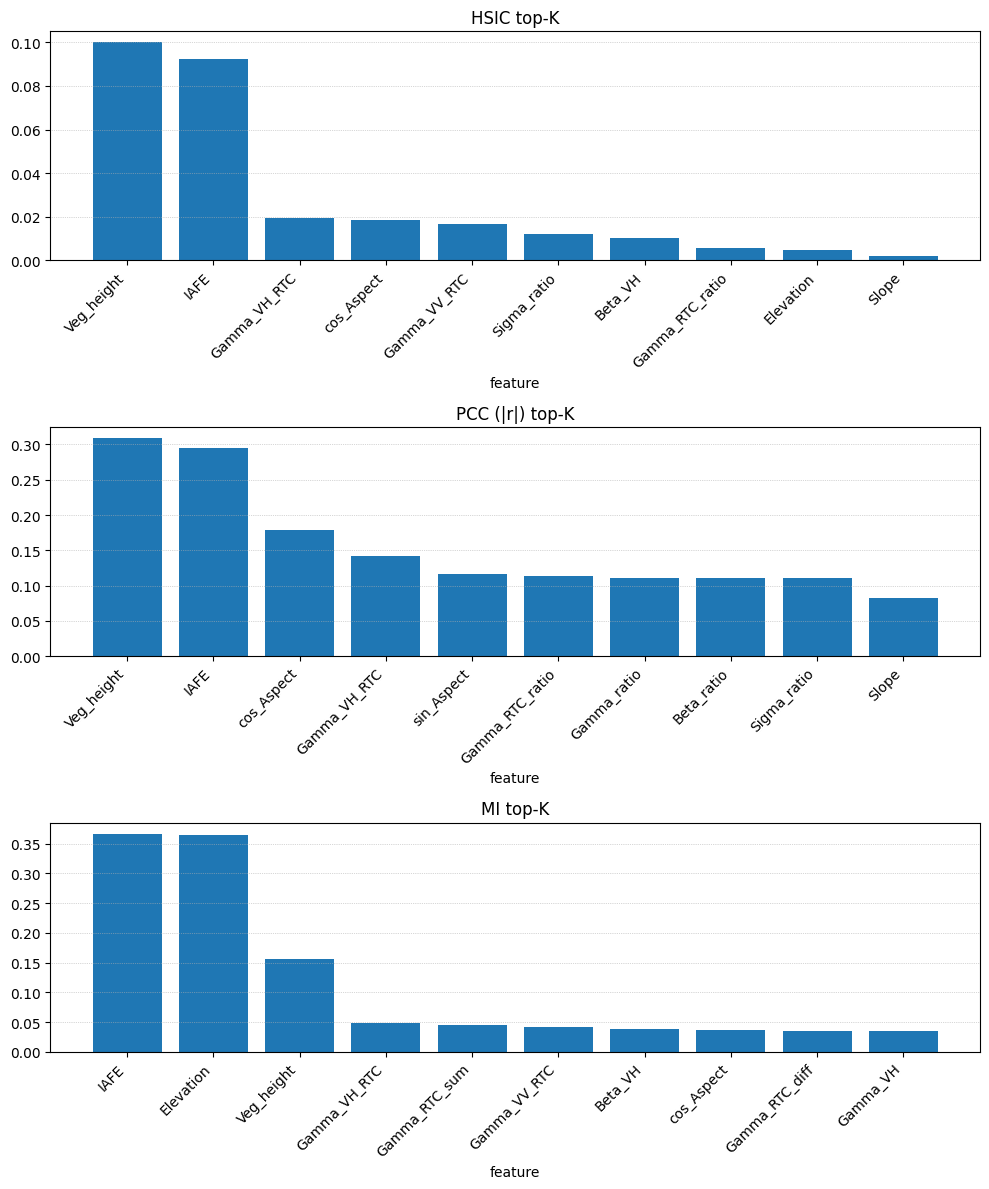

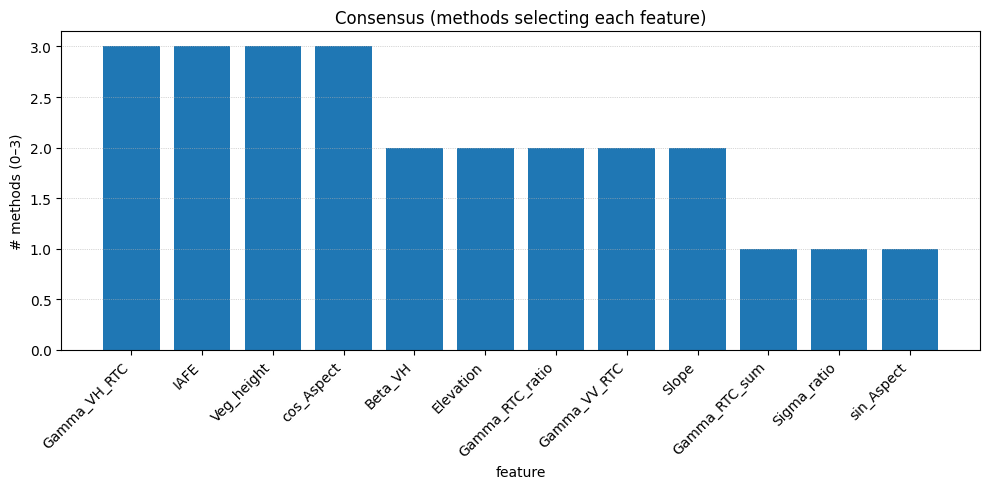

In [11]:
# Prep top-k tables (ensure consistent columns)
hsic_tbl = hsic_top.copy()  # columns: ['feature','score']
hsic_tbl = hsic_tbl.head(TOP_K).reset_index(drop=True)

pcc_tbl  = pcc_rank.loc[:, ['feature','abs_pcc']].head(TOP_K).reset_index(drop=True)
mi_tbl   = mi_rank.loc[:, ['feature','mi']].head(TOP_K).reset_index(drop=True)

def bar(ax, names, values, title, xlabel):
    ax.bar(range(len(values)), values)
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(names, rotation=45, ha="right")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.grid(True, axis='y', linestyle=':', linewidth=0.5)

# Top-K bars for each method
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
bar(axes[0], hsic_tbl['feature'], hsic_tbl['score'], "HSIC top-K", "feature")
bar(axes[1], pcc_tbl['feature'],  pcc_tbl['abs_pcc'], "PCC (|r|) top-K", "feature")
bar(axes[2], mi_tbl['feature'],   mi_tbl['mi'],       "MI top-K", "feature")
plt.tight_layout()
plt.show()


# Consensus across methods (how many picked each)
cons_counts = {}
for f in hsic_selected: cons_counts[f] = cons_counts.get(f, 0) + 1
for f in pcc_selected:  cons_counts[f] = cons_counts.get(f, 0) + 1
for f in mi_selected:   cons_counts[f] = cons_counts.get(f, 0) + 1
cons_df = (pd.DataFrame({"feature": list(cons_counts.keys()),
                         "n_methods": list(cons_counts.values())})
           .sort_values(["n_methods","feature"], ascending=[False, True]))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bar(ax, cons_df['feature'], cons_df['n_methods'], "Consensus (methods selecting each feature)", "feature")
ax.set_ylabel("# methods (0–3)")
plt.tight_layout(); plt.show()
